In [1]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize']=(15,8)


# Naiwny klasyfikator Bayesa
Autor: Jarosław Żygierewicz

Z klasyfikatorem tym zapoznamy się próbując klasyfikować gatunki irysów. Jest to klasyczny już problem, często wykorzystywany przy porównywaniu różnych technik klasyfikacji. Więcej o pochodzeniu tych danych i problemie można przeczytać tu [https://en.wikipedia.org/wiki/Iris_flower_data_set]

Kod napiszemy w oparciu o implementacje klasyfikatora Bayesa z biblioteki <tt>scikit-learn</tt> [http://scikit-learn.org/stable/about.html#citing-scikit-learn]

Zaczerpniemy stamtąd:
* obiekt klasyfikatora <tt>GaussianNB</tt>
* zbiór danych
* funkcje do oceny jakości 

Zatem importujemy:

In [2]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Przyda nam się potem funkcja rysująca dwuwymiarowe rozkłady Gaussa

In [3]:
def plot_gauss(mu, sigma, xx, yy):
    ''' Funkcja rysująca kontury funkcji gęstości prawdopodobieństwa 
       dwuwymiarowego rozkładu Gaussa'''
    # ravel spłaszcza, c_ konkatenuje wzdłuż drugiej osi
    XX = np.c_[xx.ravel(), yy.ravel()]    
    R = XX - mu 
    # odwracamy macierz kowariancji
    invS = np.linalg.inv(np.diag(sigma))
    z = np.zeros(len(R))
    for i in range(len(R)):
        # liczymy wartosci Gaussa
        z[i] = np.exp(-0.5*np.dot( R[i,:].T,np.dot(invS,R[i,:])))
    z.shape = xx.shape
    #plt.figure()
    # rysujemy kontury z wypełnieniem
    plt.contourf(xx, yy, z, alpha = 0.4, cmap='afmhot')
    plt.plot(mu[0],mu[1],'s')
    #plt.show()

## Zbiór danych irys
Zapoznajemy się z danymi i wybieramy ich podzbiór do dalszej zabawy.

Ładujemy dane

In [4]:
iris = datasets.load_iris() #https://en.wikipedia.org/wiki/Iris_flower_data_set

Zobaczmy co ten zbiór ma w środku:

In [5]:
print(dir(iris))

['DESCR', 'data', 'feature_names', 'filename', 'frame', 'target', 'target_names']


Wypiszemy sobie opis danych:

In [6]:
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Wypiszmy nazwy gatunków:

In [7]:
print(iris['target_names'])

['setosa' 'versicolor' 'virginica']


Wypiszmy nazwy cech:

In [8]:
print(iris['feature_names'])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Wypiszmy kodowanie gatunków. To są wyjścia, które chcielibyśmy uzyskać od wytrenowanego klasyfikatora:

In [9]:
print(iris['target'])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Wypiszmy wartości cech. Są to dane wejściowe do klasyfkiacji. 

In [10]:
print(iris['data'])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

Zatem, np. obserwacja nr 5 ma cechy:

In [11]:
print(iris.data[5,:])

[5.4 3.9 1.7 0.4]


i ma przypisaną klasę:

In [12]:
print(iris.target[5])

0


Czyli jest to gatunek:

In [13]:
print(iris.target_names[iris.target[5]])

setosa


## Ilustrowanie własności zbioru danych

Do rysowania zależniści między cechami i klasami przyda nam się własną mapę kolorów:

In [14]:
color_map = {-1: (1, 1, 1), 0: (0, 0, .9), 1: (1, 0, 0), 2: (.5, .5, 0)}

Wytwarzamy wektor, który każdemu wierszowi w tabeli danych przypisze kolor odpowiadający gatunkowi irysa

In [15]:
colors = [color_map[y] for y in iris.target]

### Aby przyjrzeć się zbiorowi danych warto zbadać: 
#### 1) Rozkłady cech w klasach: 
* np. histogramy. Proszę wykreślić histogramy rozkładu cech w poszczególnych klasach:

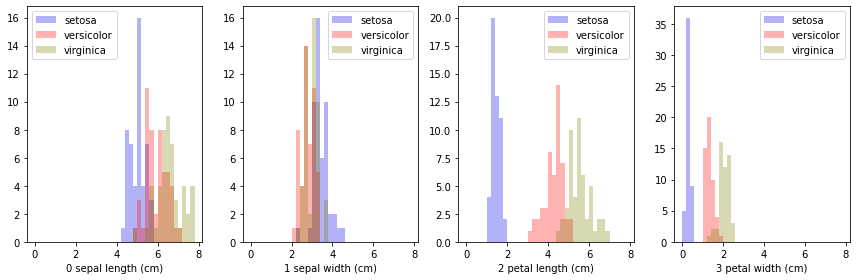

In [16]:
# tworzymy nowy obiekt figure
plt.figure(figsize=(12,4))
# wykonujemy pętlę for po cechach
for f, f_name in enumerate(iris['feature_names']):
    # tworzymy nowy podwykres
    plt.subplot(1, 4, f+1)
    # iterujemy po klasach, żeby narysować trzy histogramy na jednym wykresie
    for k in range(3): # k - klasa
        # rysujemy histogram z odpowiednim kolorem i
        # MIEJSCE NA TWÓJ KOD
        plt.hist(...)
    # dodajemy podpis do osi OX
    plt.xlabel(str(f)+' '+ f_name)
    # dodajemy legendę
    plt.legend()
# magiczna formułka rozkładająca wykresy w estetyczny sposób tak, żeby nie nachodziły na siebie
plt.tight_layout()
# pokazujemy wykresy
plt.show() 

## Violinplot

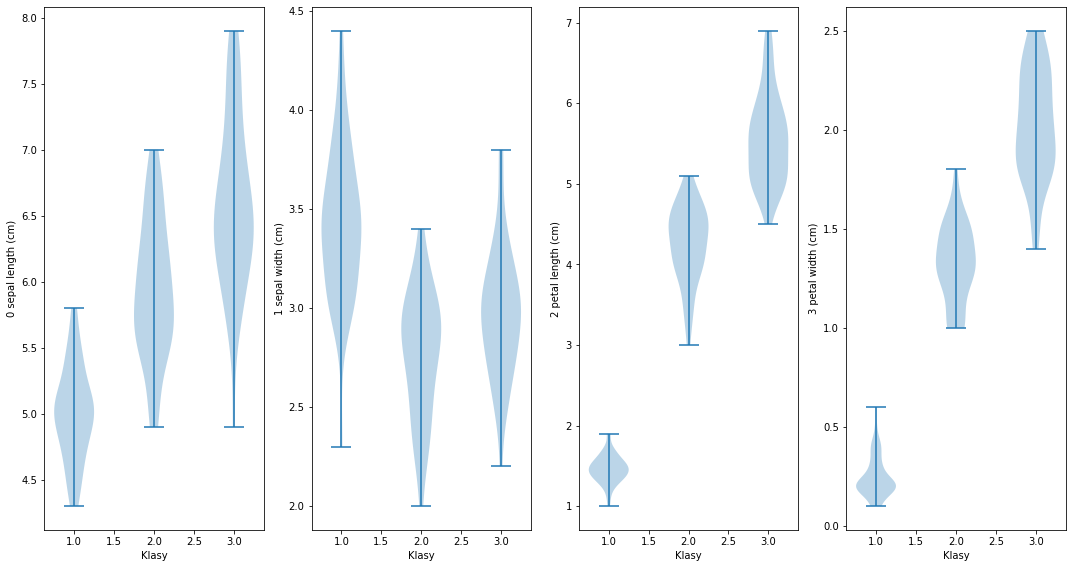

In [17]:
# tworzymy obiekt typu figure
plt.figure()
# iterujemy po cechach
for f, f_name in enumerate(iris['feature_names']):
    # dodajemy podwykres
    plt.subplot(1,4,f+1)
    # tablica zer
    data = np.zeros((50,3))
    # iterujemy po klasach
    for k in range(3): 
        # wybieramy dane ze zbioru odpowiadające cesze f i klasie k, i wpisujemy do tablicy
        # żeby je później wyświetlić
        # MIEJSCE NA TWÓJ KOD
        ...  
    # tworzymy wykres typu violinplot
    # MIEJSCE NA TWÓJ KOD
    ...
    # dodajemy etykiety osi
    plt.ylabel(str(f) + ' ' + f_name)
    plt.xlabel('Klasy')
# magiczna formułka rozkładająca wykresy w estetyczny sposób tak, żeby nie nachodziły na siebie
plt.tight_layout()
# pokazujemy wykres
plt.show() 

#### Strukturę korelacji
Tu zwróćmy uwagę na orientację macierzy podawanej do funkcji `np.cov`:

(4, 4)


<Figure size 1080x576 with 0 Axes>

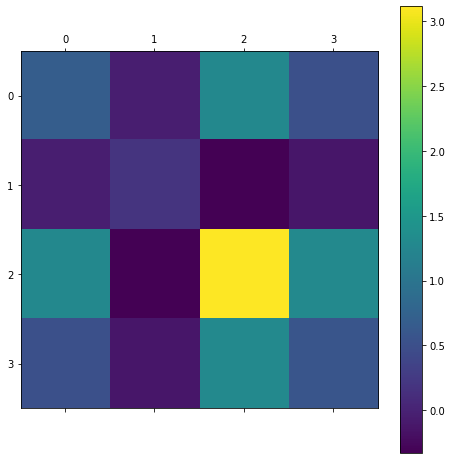

[[ 0.68569351 -0.042434    1.27431544  0.51627069]
 [-0.042434    0.18997942 -0.32965638 -0.12163937]
 [ 1.27431544 -0.32965638  3.11627785  1.2956094 ]
 [ 0.51627069 -0.12163937  1.2956094   0.58100626]]


In [18]:
# tworzyy macierz kowariancji przy użyciu np.cov
rho = np.cov(iris.data.T)
print(rho.shape)

plt.figure()
# wysujemy ją jako mapę kolorów używając plt.matshow()
# MIEJSCE NA TWÓJ KOD
...
# dodajemy colorbar
# MIEJSCE NA TWÓJ KOD
...
# pokazujemy obrazek
plt.show()
print(rho)

***Stukturę korelacji i rozkłady można też podsumować na takim rysunku:***
* w siatce prostokątnej rysujemy 
  * na przekątnej histogramy grupowane, lub violinploty
  * pod przekątną wykres punktowy (scaterplot)

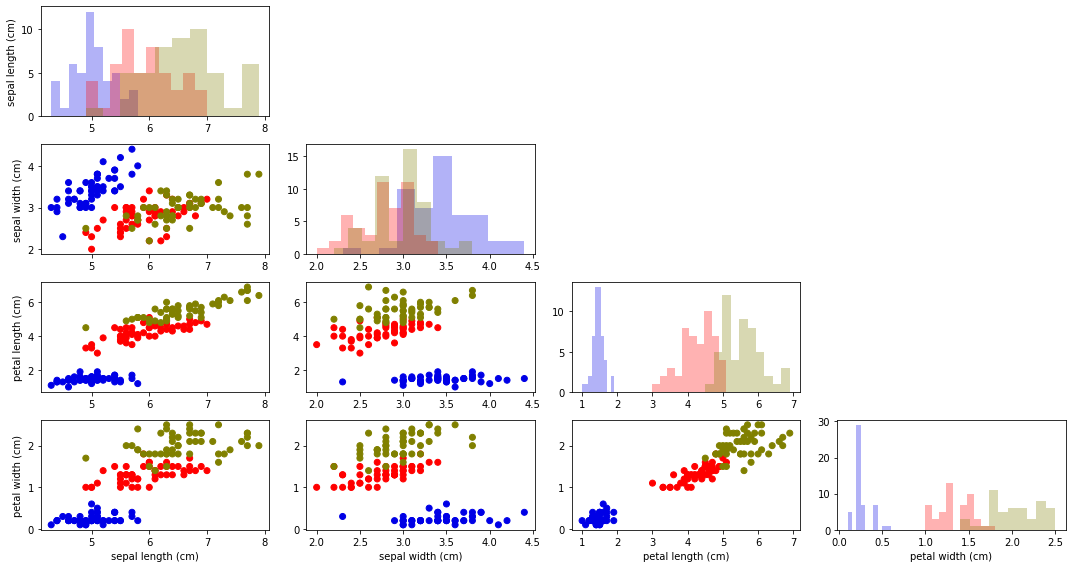

In [19]:
plt.figure(1)
# piszmy dwie pętle zagnieżdżone po cechach
for i, name_i in enumerate(iris['feature_names']):
    for j, name_j in enumerate(iris['feature_names']):
        
        # jeśli jesteśmy pod przekątną to wysujemy wykres punktowy dla cech j vs. i
        if i>j:
            # stwórz podwykres (subplot)
            ... # "i" numeruje wiersze, "j" kolumny
            # narysuj scatter plot używając tablicy "colors"
            ...
        # jeżeli jesteśmy na przekątnej to rysujemy histogramy/violinploty jak poprzednio
        elif i==j:
            # stwórz podwykres (subplot)
            ... # "i" numeruje wiersze, "j" kolumny
            
            # narysuj histogram/violinplot
            ...
        # jeżeli jesteśmy ponad przekątną to nie rysujemy nic
        else:
            pass
        
        # dodaj etykiety osi OY po lewej stronie rysunku i osi OX poniżej rusynku
        ...

# wyświetlamy
plt.tight_layout()
plt.show()

## Szykujemy się do zbudowania klasyfikatora
Aby było nam łatwo ilustrować jego działanie wybieramy dwie cechy (podziały przestrzeni cech da się wtedy łatwo narysować na płaszczyźnie)

* Wybieramy cechy 1 i 2 (bo są ze sobą mało skorelowane) normalizujemy je

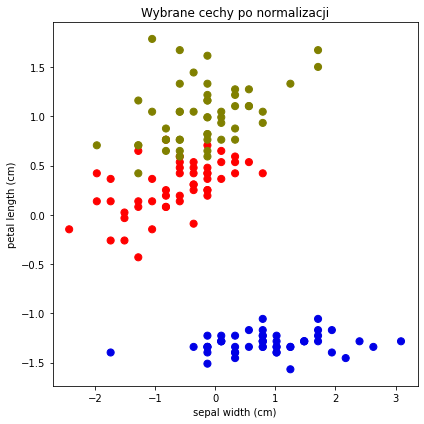

In [20]:
# stwórz tablicę zer, która pomieści podzbiór danych: wszystkie punkty ale tylko dwie cechy 
X = ...
# wpisz dane dla cechy 1 i znormalizuj je (odejmij średnią i podziel przez odchylenie standardowe)
X[:,0] = ...
# wpisz dane dla cechy 2 i znormalizuj je (odejmij średnią i podziel przez odchylenie standardowe)
X[:,1] = ...
# narysuj wykres punktowy z odpowiednimi kolorami, etykietami itp
...

## Tworzymy i uczymy klasyfikator
Poniżej znajduje się kod służący klasyfikacji. Proszę go uzupełnić zgodnie z komentarzami i dokumentacją:

https://scikit-learn.org/stable/modules/naive_bayes.html

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [21]:
from sklearn.naive_bayes import GaussianNB
# stwórz instancję klasyfikatora Gaussian Naive Bayes
gnb = ...
# wpisz tutaj wartości klas ze zbioru danych
Y = ...
# dofituj parametry klasyfikatora 
...

GaussianNB()

#### Przedstaw rozkłady Gaussa, które zostały dopasowane do danych, skorzystaj z funkcji plot_gauss()
* średnie tych rozkładów są w gnb.theta_
* standardowe odchylenia są w gnb.sigma_

Przygotowanie siatki na której będą rysowane kontury Gaussów

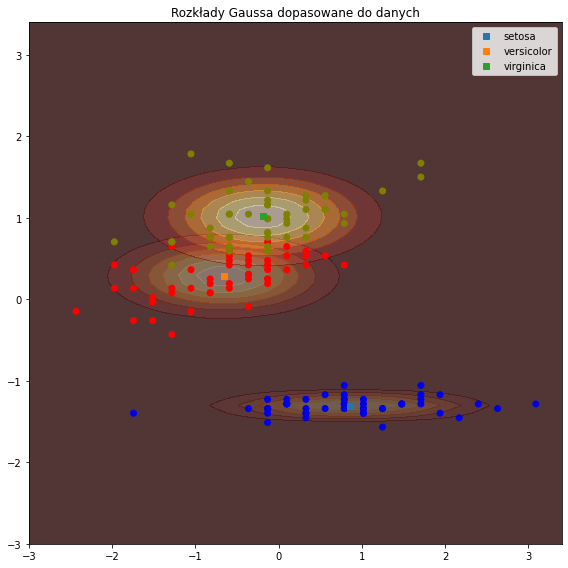

In [22]:
x_min, x_max = -3, 3.5
y_min, y_max = -3, 3.5
# użyj funkcji np.meshgrid aby stworzyć siatkę punktów pomiędzy zdefiniowanymi
# powyżej wartościami iksów i igreków, odległość między punktami niech wynosi 0.1
# dla obu wymiarów
xx, yy = np.meshgrid(...)

plt.figure(figsize=(8,8))
# użyj funkcji plot_gauss() żeby narysować rozkłady dla wszystkich trzech klas (użyj for)
for i in range(3):
    ...
    
# dorzućmy do rysunku jeszcze oryginalne dane
# narysuj wykres punktowy
...
# estetyka
plt.title(u'Rozkłady Gaussa dopasowane do danych')
plt.legend(iris['target_names'])
plt.tight_layout()
plt.show()        

## Rysowanie wyników klasyfikacji             
Przekształcamy siatkę w macierz dwukolumnową - kolumny odpowiadają cechom

In [23]:
XX = np.c_[xx.ravel(), yy.ravel()]
print(XX.shape)

(4225, 2)


Dla każdego punktu siatki oblicz predykcję klasyfikatora  

In [24]:
# policz predykcję klasyfikatora na XX
Z = ...
print(Z.shape)

(4225,)


Te predykcje narysujemy w przestrzeni cech za pomocą funkcji  plt.contourf 

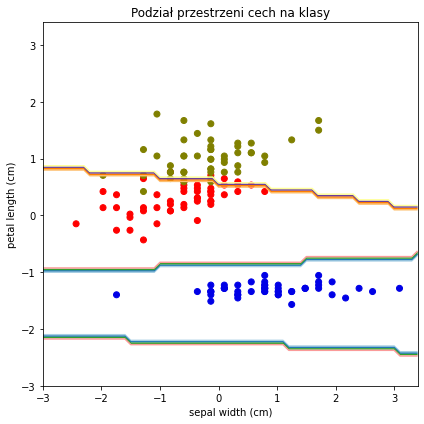

In [25]:
plt.figure(figsize=(6,6))
# nadaj Z odpowiedni wymiar, żeby narysować predykcję w przestrzeni cech
Z = Z.reshape(...)
# narysuj contour z mapą kolorów "plt.cm.Paired"
plt.contour(...)
# i dorzucamy oryginalne punkty -- wykres punktowy
plt.scatter(...)
# estetyka
plt.title(u'Podział przestrzeni cech na klasy')
plt.xlabel(iris['feature_names'][1])
plt.ylabel(iris['feature_names'][2])
plt.tight_layout()
plt.show()

## Ewaluacja modelu
Teraz zajmiemy się ewaluacją dopasowanego modelu (walidacja krzyżowa). Skorzystamy z funkcji dostrczanych przez [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
* upewnij się, że dokładnie rozumiesz co zwracają te funkcje [(sprawdź w dokumentacji)]
* porównaj z definicjami z [wykładu](https://brain.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/Wyk%C5%82ad_Ocena_jako%C5%9Bci_klasyfikacji) 

In [26]:
# użyj classification_report() żeby policzyć najpopularniejsze miary 
print("Classification report:")
print(classification_report(...))
# wypisz macierz pomyłek NIE LICZ SAMEMU TYLKO UŻYJ POZNANEJ FUNKCJI
print("Confusion matrix:")
print(...)

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.85      0.92      0.88        50
           2       0.91      0.84      0.87        50

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150

Confusion matrix:
[[50  0  0]
 [ 0 46  4]
 [ 0  8 42]]


## Porównanie  modeli
Stwórz trzy modele klasyfikatorów:
* pierwszym niech będzie korzystał z cech 1 i 2 (nasz dotychczasowy model)
* drugim niech korzysta tylko z cech 0 i 1
* trzeci niech korzysta ze wszytkich 4 cech

Porównaj miary jakości tych modeli otrzymywane za pomocą walidacji krzyżowej.

* Trzeci model można też stworzyć dla danych normalizowanych i nienormalizowanych, aby sprzwdzić czy normalizacja w tym przypadku pomaga w prawidłowej klasyfikacji.

In [27]:
# Stwórz i dopasuj ponownie model 1
...

In [28]:
# Stwórz model 2
...

In [29]:
# Stwórz model 3
...

In [30]:
# Policz miary jakości i porównaj dla powyższych trzech modeli
...

In [31]:
# Stwórz model 4, bez normalizacji danych
...

In [32]:
# Policz miary jakości dla modelu 4 i porównaj z modelem nr 3
...